In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import RidgeCV, LassoCV

import warnings

warnings.filterwarnings('ignore')

train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

In [53]:
train['SalePrice'].describe()

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: SalePrice, dtype: float64

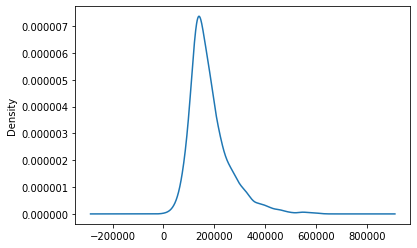

In [54]:
y = train['SalePrice']
y.plot(kind = 'kde');

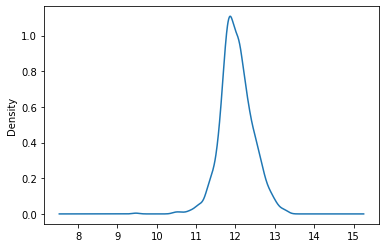

In [55]:
y_log = np.log(train['SalePrice'].copy())
y_log.plot(kind = 'kde')

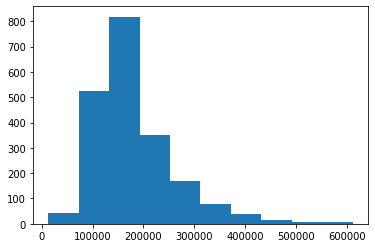

In [56]:
#Skewed, so let's build a model around the log.
plt.hist(y);

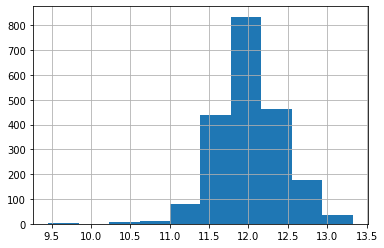

In [57]:
# a bit more normal, need to do something about outliers
y.map(np.log).hist()

In [58]:
non_null_columns = train.isnull().sum()[train.isnull().sum() == 0].index


In [59]:
df_numeric = train[non_null_columns]._get_numeric_data()


In [60]:
list(df_numeric.columns)

['Id',
 'PID',
 'MS SubClass',
 'Lot Area',
 'Overall Qual',
 'Overall Cond',
 'Year Built',
 'Year Remod/Add',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'TotRms AbvGrd',
 'Fireplaces',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'Mo Sold',
 'Yr Sold',
 'SalePrice']

In [61]:
df_numeric['age sale'] = train['Yr Sold'] - train['Year Built']
df_numeric['age remod'] = train['Yr Sold'] - train['Year Remod/Add']
df_numeric['total baths'] = df_numeric['Full Bath'] + df_numeric['Half Bath']


In [62]:
list(df_numeric.columns)

['Id',
 'PID',
 'MS SubClass',
 'Lot Area',
 'Overall Qual',
 'Overall Cond',
 'Year Built',
 'Year Remod/Add',
 '1st Flr SF',
 '2nd Flr SF',
 'Low Qual Fin SF',
 'Gr Liv Area',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'Kitchen AbvGr',
 'TotRms AbvGrd',
 'Fireplaces',
 'Wood Deck SF',
 'Open Porch SF',
 'Enclosed Porch',
 '3Ssn Porch',
 'Screen Porch',
 'Pool Area',
 'Misc Val',
 'Mo Sold',
 'Yr Sold',
 'SalePrice',
 'age sale',
 'age remod',
 'total baths']

In [63]:
X = df_numeric.drop(columns = ['Id', 'PID', 'MS SubClass', 'SalePrice'])
y = df_numeric['SalePrice']

In [64]:
poly = PolynomialFeatures(degree = 2, include_bias = False)
X_overfit = poly.fit_transform(X)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_overfit, y, random_state = 42)

In [66]:
y_train_log = y_train.map(np.log)
y_test_log = y_test.map(np.log)


In [67]:
train_baseline = [np.mean(y_train) for i in y_train]
test_baseline = [np.mean(y_test) for i in y_test]

In [68]:
mean_squared_error(y_train, train_baseline) ** .5

79526.85223710592

In [69]:
mean_squared_error(y_test, test_baseline) ** .5

78358.30989953087

## First model

In [70]:
lr = LinearRegression()
lr.fit(X_train, y_train)
def evaluate_model(model, X, y):
    '''
    Evaluate our model using three metrics given X and y data
    Prints out results for r2, mse, rmse
    '''
    print(f'R2 Score: {r2_score(y, model.predict(X))}')
    print(f'MSE: {mean_squared_error(y, model.predict(X))}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y, model.predict(X)))}')

In [71]:
evaluate_model(lr, X_train, y_train)

R2 Score: 0.9343419575108975
MSE: 415255617.7706457
RMSE: 20377.82171309401


In [72]:
evaluate_model(lr, X_test, y_test)

R2 Score: -0.08226214833052792
MSE: 6645116355.428865
RMSE: 81517.58310590952


## Second Model: Standardize the data

In [73]:
## Instantiate StandardScaler
ss = StandardScaler()

## Fit to X_train
ss.fit(X_train)

## Transform both train and test data
Z_train = ss.transform(X_train)
Z_test = ss.transform(X_test)

In [74]:
## Instantiate Ridge model with alpha = 100 
ridge = Ridge(alpha = 100)

## Fit Ridge model to scaled training data

ridge.fit(Z_train, y_train)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [75]:
evaluate_model(ridge, Z_train, y_train)

R2 Score: 0.9150403762589618
MSE: 537328858.8066263
RMSE: 23180.35501899456


In [76]:
evaluate_model(ridge, Z_test, y_test)

R2 Score: 0.8659754203160667
MSE: 822914233.7288771
RMSE: 28686.481724479163


## Third Model: lr with Lasso

In [77]:
## Instantiate Lasso model with alpha = 100 
lasso = Lasso(alpha = 100)

## Fit Lasso model to scaled training data
lasso.fit(Z_train, y_train)

Lasso(alpha=100, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [78]:
evaluate_model(lasso, Z_train, y_train)

R2 Score: 0.9214883693694416
MSE: 496548395.9575009
RMSE: 22283.365902787238


In [79]:
evaluate_model(lasso, Z_test, y_test)

R2 Score: 0.8373432578367912
MSE: 998716419.4339088
RMSE: 31602.474894126706


## Best Alpha?
### Ridge CV

In [81]:
## We'll use np.logspace() to generate 100 values equally between 0 and 5
## and then convert them to values between 10^0 and 10^5
ridge_alphas = np.logspace(0, 5, 100)
#can use lin space to do this without log
#np.linspace(0,5,100)


## Instantiate RidgeCV
ridge_cv = RidgeCV(alphas = ridge_alphas, scoring = 'r2', cv = 5)

## Fit to scaled training data
ridge_cv.fit(Z_train, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       1.09749877e+04, 1.23284674e+04, 1.38488637e+04, 1.55567614e+04,
       1.74752840e+04, 1.96304065e+04, 2.20513074e+04, 2.47707636e+04,
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring='r2',
        store_cv_values=False)

In [82]:
evaluate_model(ridge_cv, Z_train, y_train)

R2 Score: 0.8879883184864602
MSE: 708420145.3638192
RMSE: 26616.16323521892


In [83]:
evaluate_model(ridge_cv, Z_test, y_test)

R2 Score: 0.8791441813917608
MSE: 742057715.0565596
RMSE: 27240.736316343573


In [84]:
ridge_cv.alpha_

673.4150657750821

### Lasso CV

In [85]:
## We'll use np.logspace() to generate 100 values equally between 0 and 5
## and then convert them to values between 10^0 and 10^5
lasso_alphas = np.logspace(0, 5, 100)

## Instantiate LassoCV
lasso_cv = LassoCV(alphas = lasso_alphas, cv = 5)

## Fit to scaled training data
lasso_cv.fit(Z_train, y_train)

LassoCV(alphas=array([1.00000000e+00, 1.12332403e+00, 1.26185688e+00, 1.41747416e+00,
       1.59228279e+00, 1.78864953e+00, 2.00923300e+00, 2.25701972e+00,
       2.53536449e+00, 2.84803587e+00, 3.19926714e+00, 3.59381366e+00,
       4.03701726e+00, 4.53487851e+00, 5.09413801e+00, 5.72236766e+00,
       6.42807312e+00, 7.22080902e+00, 8.11130831e+00, 9.11162756e+00,
       1.02353102e+01, 1.14975700e+0...
       2.78255940e+04, 3.12571585e+04, 3.51119173e+04, 3.94420606e+04,
       4.43062146e+04, 4.97702356e+04, 5.59081018e+04, 6.28029144e+04,
       7.05480231e+04, 7.92482898e+04, 8.90215085e+04, 1.00000000e+05]),
        copy_X=True, cv=5, eps=0.001, fit_intercept=True, max_iter=1000,
        n_alphas=100, n_jobs=None, normalize=False, positive=False,
        precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
        verbose=False)

In [86]:
evaluate_model(lasso_cv, Z_train, y_train)

R2 Score: 0.8427414329020273
MSE: 994584988.439668
RMSE: 31537.041529599253


In [87]:
evaluate_model(lasso_cv, Z_test, y_test)

R2 Score: 0.8619103281282031
MSE: 847874000.2933528
RMSE: 29118.276052907953


In [88]:
lasso_cv.alpha_

4328.761281083057

## Feature Importances

In [89]:
## Check the coefficients for our first linear regression model
lr_coef_df = pd.DataFrame({
    'X' : poly.get_feature_names(X.columns),
    'coef' : lr.coef_, 
    'abs_coef' : np.abs(lr.coef_)
})

lr_coef_df.sort_values(by = 'abs_coef', ascending = False)

,X,coef,abs_coef
12,Kitchen AbvGr,1.213464e+07,1.213464e+07
13,TotRms AbvGrd,-2.806643e+06,2.806643e+06
14,Fireplaces,1.734169e+06,1.734169e+06
1,Overall Qual,1.270366e+06,1.270366e+06
11,Bedroom AbvGr,9.574230e+05,9.574230e+05
...,...,...,...
208,Low Qual Fin SF Pool Area,1.586506e-05,1.586506e-05
206,Low Qual Fin SF 3Ssn Porch,1.256144e-05,1.256144e-05
361,3Ssn Porch Screen Porch,0.000000e+00,0.000000e+00
362,3Ssn Porch Pool Area,0.000000e+00,0.000000e+00


In [90]:
## Check the coefficients for our ridge model
ridge_coef_df = pd.DataFrame({
    'X' : poly.get_feature_names(X.columns),
    'coef' : ridge_cv.coef_, 
    'abs_coef' : np.abs(ridge_cv.coef_)
})

ridge_coef_df.sort_values(by = 'abs_coef', ascending = False)

,X,coef,abs_coef
58,Overall Qual 1st Flr SF,4819.536124,4819.536124
54,Overall Qual^2,4500.195378,4500.195378
61,Overall Qual Gr Liv Area,4097.461463,4097.461463
47,Lot Area Pool Area,-3735.841485,3735.841485
66,Overall Qual TotRms AbvGrd,3348.547008,3348.547008
...,...,...,...
206,Low Qual Fin SF 3Ssn Porch,0.000000,0.000000
353,Enclosed Porch Pool Area,0.000000,0.000000
208,Low Qual Fin SF Pool Area,0.000000,0.000000
361,3Ssn Porch Screen Porch,0.000000,0.000000


In [96]:
ridge_coef_df[ridge_coef_df['coef'] != 0]

,X,coef,abs_coef
0,Lot Area,1545.868121,1545.868121
1,Overall Qual,2090.867909,2090.867909
2,Overall Cond,465.757471,465.757471
3,Year Built,229.700624,229.700624
4,Year Remod/Add,-360.883319,360.883319
...,...,...,...
400,age sale age remod,1276.893516,1276.893516
401,age sale total baths,-1264.607600,1264.607600
402,age remod^2,1905.294669,1905.294669
403,age remod total baths,-1797.972705,1797.972705


In [91]:
## Check the coefficients of our lasso model
lasso_coef_df = pd.DataFrame({
    'X' : poly.get_feature_names(X.columns),
    'coef' : lasso_cv.coef_, 
    'abs_coef' : np.abs(lasso_cv.coef_)
})

lasso_coef_df.sort_values(by = 'abs_coef', ascending = False)

,X,coef,abs_coef
61,Overall Qual Gr Liv Area,25488.806032,25488.806032
54,Overall Qual^2,16120.951967,16120.951967
58,Overall Qual 1st Flr SF,11231.926517,11231.926517
77,Overall Qual age sale,-9019.125902,9019.125902
47,Lot Area Pool Area,-6161.628841,6161.628841
...,...,...,...
140,Year Remod/Add Wood Deck SF,0.000000,0.000000
139,Year Remod/Add Fireplaces,0.000000,0.000000
138,Year Remod/Add TotRms AbvGrd,0.000000,0.000000
137,Year Remod/Add Kitchen AbvGr,-0.000000,0.000000


In [93]:
lasso_coef_df[lasso_coef_df['coef'] != 0]

,X,coef,abs_coef
29,Lot Area Overall Cond,3941.524418,3941.524418
46,Lot Area Screen Porch,4401.267778,4401.267778
47,Lot Area Pool Area,-6161.628841,6161.628841
54,Overall Qual^2,16120.951967,16120.951967
58,Overall Qual 1st Flr SF,11231.926517,11231.926517
61,Overall Qual Gr Liv Area,25488.806032,25488.806032
66,Overall Qual TotRms AbvGrd,5655.391218,5655.391218
67,Overall Qual Fireplaces,5236.435695,5236.435695
77,Overall Qual age sale,-9019.125902,9019.125902
78,Overall Qual age remod,-3470.933300,3470.933300
